In [192]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

df = pd.read_csv("./dataset/valeurs-foncieres-2005-nice-cleansed.csv")#, on_bad_lines='skip')
df.drop(columns=["nom_commune", "longitude", "latitude"], inplace=True)
df.head()

,Index,valeur_fonciere,code_postal,code_commune,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain
0,801,740000.0,6200.0,6088,0,2.0,Appartement,0.331295,0.488678,0.400593
1,803,740000.0,6200.0,6088,0,2.0,Appartement,-0.757895,-0.977356,0.400593
2,804,740000.0,6200.0,6088,0,2.0,Appartement,-0.733691,-0.977356,0.400593
3,805,740000.0,6200.0,6088,0,2.0,Appartement,-0.830508,-0.977356,0.400593
4,806,740000.0,6200.0,6088,0,2.0,Appartement,-0.878916,-0.977356,0.400593


In [193]:
from zlib import crc32
import numpy as np

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

df.reset_index(inplace=True)
df.drop(columns=["Index"], inplace=True)
df.head()

,index,valeur_fonciere,code_postal,code_commune,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain
0,0,740000.0,6200.0,6088,0,2.0,Appartement,0.331295,0.488678,0.400593
1,1,740000.0,6200.0,6088,0,2.0,Appartement,-0.757895,-0.977356,0.400593
2,2,740000.0,6200.0,6088,0,2.0,Appartement,-0.733691,-0.977356,0.400593
3,3,740000.0,6200.0,6088,0,2.0,Appartement,-0.830508,-0.977356,0.400593
4,4,740000.0,6200.0,6088,0,2.0,Appartement,-0.878916,-0.977356,0.400593


In [194]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression 
preprocessor = ColumnTransformer(
    transformers=[
        #('tfidf1', TfidfVectorizer(), 'Commune'),
        ('onehot1', OneHotEncoder(sparse_output=False, dtype=int), ['type_local']),
    ],
    remainder='passthrough'  # Keep all other columns
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

In [195]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "index")
X_train=train_set.drop(['valeur_fonciere'], axis=1)
y_train=train_set['valeur_fonciere']

In [ ]:
model.fit(X_train, y_train)
score=model.score(X_train, y_train)
print("R² score training:", score)
#https://medium.com/@shanu9494/simple-linear-regression-using-rmse-as-cost-function-d5731da8dfa0

X_test=test_set.drop(['valeur_fonciere'], axis=1)
y_test=test_set['valeur_fonciere']
score = model.score(X_test, y_test)
print("R² score test:", score)

R² score test: 0.28033357529687464


In [197]:
# Get feature names
feature_names = model.named_steps["preprocess"].get_feature_names_out()

# Get coefficients
coeffs = model.named_steps["regressor"].coef_

# Pair them
weights = pd.Series(coeffs, index=feature_names)
print(weights.sort_values)

<bound method Series.sort_values of onehot1__type_local_Appartement         0.000000e+00
remainder__index                       -2.323834e+03
remainder__code_postal                 -2.503425e+03
remainder__code_commune                 2.451683e+03
remainder__nombre_lots                 -5.703907e+05
remainder__code_type_local             -2.910383e-11
remainder__surface_reelle_bati         -4.953239e+04
remainder__nombre_pieces_principales    1.253810e+05
remainder__surface_terrain              3.485457e+05
dtype: float64>


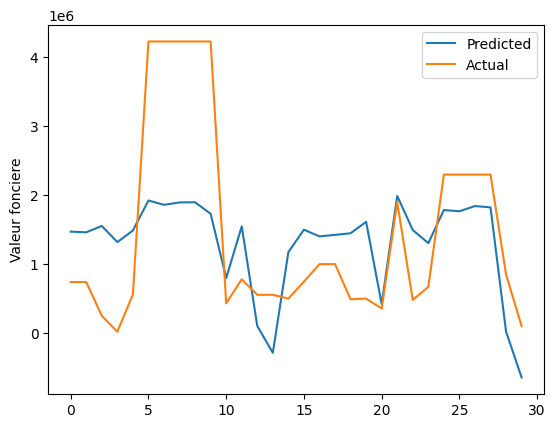

R² score predict: 0.28033357529687464


In [198]:
import matplotlib.pyplot as plt
y_predict=model.predict(X_test)
plt.plot(y_predict, label='Predicted')
plt.plot(y_test.values, label='Actual')
plt.ylabel('Valeur fonciere')

plt.legend()
plt.show()

score = model.score(X_test, y_test)
print("R² score predict:", score)